### `Import the main Libraries`

In [66]:
## Major
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import re
import string
from tqdm import tqdm # progress bar 
import joblib

## plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## nltk -- for text processing
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk import word_tokenize
from nltk import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

## sklearn -- for processing and models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## SMOTE for imblanced dataset
from imblearn.over_sampling import SMOTE

## Optimization Algorithm using Jaya Optimizer
from mealpy.swarm_based.JA import BaseJA, OriginalJA, LevyJA

## Filter Warnings
import warnings
warnings.filterwarnings('ignore')

### `Load the Dataset & Look at the big picture`

In [67]:
## Readind using pandas
df = pd.read_csv('testdata.manual.2009.06.14.csv', 
                 encoding='ISO-8859-1', names=['target', 'id', 'date', 'flags', 'user', 'text'])
df.head()

,target,id,date,flags,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is good read.
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)


----

### `Exploratory Data Analyis`

In [68]:
print('The Shape of the Dataset is: ', df.shape)

The Shape of the Dataset is:  (498, 6)


In [69]:
## Check the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  498 non-null    int64 
 1   id      498 non-null    int64 
 2   date    498 non-null    object
 3   flags   498 non-null    object
 4   user    498 non-null    object
 5   text    498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


In [70]:
## DataTypes
df.dtypes

target     int64
id         int64
date      object
flags     object
user      object
text      object
dtype: object

In [71]:
## check null values
df.isna().sum(axis=0)  ## ok

target    0
id        0
date      0
flags     0
user      0
text      0
dtype: int64

In [72]:
## Check the Traget values
df['target'].unique()      # 0-> -ve, 2 -> normal, 4-> +ve

array([4, 0, 2])

In [73]:
## Distr. of target
df['target'].value_counts()  ## imblanced dataset -- 4:Positive, 0: Negative, 2: Neutral

4    182
0    177
2    139
Name: target, dtype: int64

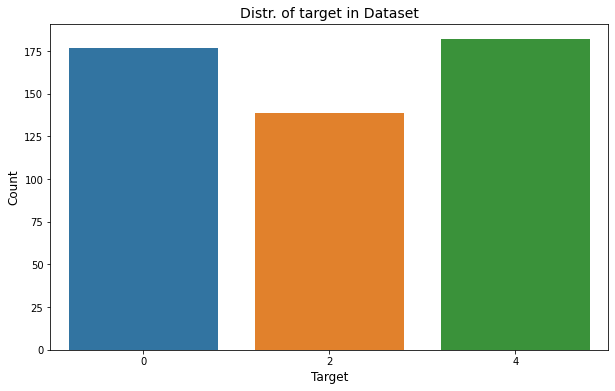

In [74]:
## countplot of target
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='target')
plt.title('Distr. of target in Dataset', fontsize=14, c='k')
plt.xlabel('Target', c='k', fontsize=12)
plt.ylabel('Count', c='k', fontsize=12)
plt.show()

In [75]:
## take a deep copy from the DF
dataset = df[['target', 'text']]
dataset

,target,text
0,4,"@stellargirl I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,@kenburbary You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,@mikefish Fair enough. But i have the Kindle2 and I think it's perfect :)
...,...,...
493,2,Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] http://tinyurl.com/myfmf7
494,0,"On that note, I hate Word. I hate Pages. I hate LaTeX. There, I said it. I hate LaTeX. All you TEXN3RDS can come kill me now."
495,4,Ahhh... back in a *real* text editing environment. I &lt;3 LaTeX.
496,0,"Trouble in Iran, I see. Hmm. Iran. Iran so far away. #flockofseagullsweregeopoliticallycorrect"


----

### `Text Cleaning & Visualization`

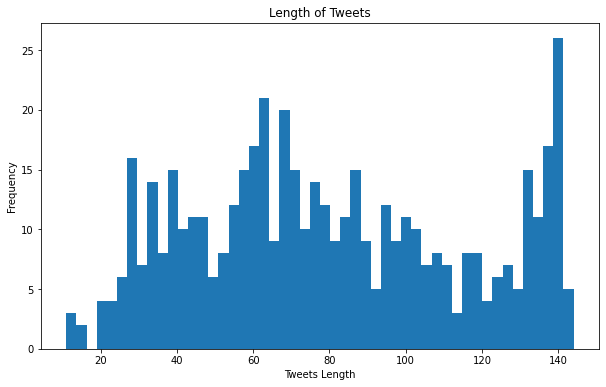

In [76]:
## Check Length of Tweets
length_tweets = dataset['text'].str.len()
## Plotting
plt.figure(figsize=(10, 6))
plt.hist(length_tweets, bins=50)
plt.title('Length of Tweets')
plt.xlabel('Tweets Length')
plt.ylabel('Frequency')
plt.show()

In [77]:
## Hashtags
def hashtag_extract(x):
    hashtags = []
    ## Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)

    return hashtags

## Extracting hashtags from non racist tweets # slicing
hash_neg = hashtag_extract(dataset['text'][dataset['target'] == 0])  ## Negative
hash_pos = hashtag_extract(dataset['text'][dataset['target'] == 4])  ## Positive
hash_neu = hashtag_extract(dataset['text'][dataset['target'] == 2])  ## Neutral

## Unnesting list
hash_neg = sum(hash_neg, [])
hash_pos = sum(hash_pos, [])
hash_neu = sum(hash_neu, [])

In [78]:
hash_neg

['p2',
 'bipart',
 'tlot',
 'tcot',
 'hhrs',
 'GOP',
 'DNC',
 'd',
 'at',
 'att',
 'wolfram',
 'google',
 'wikipedia',
 'tcot',
 'ala',
 'RantsAndRaves',
 'WFTB',
 'iranelection',
 'flockofseagullsweregeopoliticallycorrect']

In [79]:
## Hashtags in Tweets # same value count
a_neg = nltk.FreqDist(hash_neg)
a_pos = nltk.FreqDist(hash_pos)
a_neu = nltk.FreqDist(hash_neu)

a_neg

FreqDist({'tcot': 2, 'p2': 1, 'bipart': 1, 'tlot': 1, 'hhrs': 1, 'GOP': 1, 'DNC': 1, 'd': 1, 'at': 1, 'att': 1, ...})

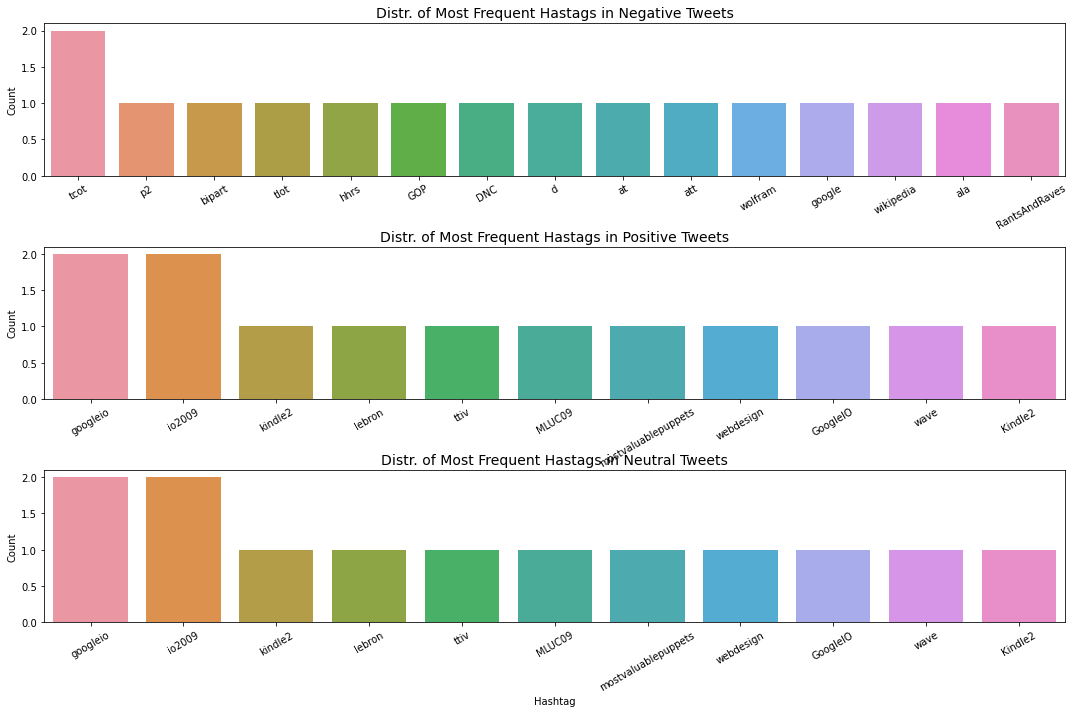

In [80]:
## Hashtags in Tweets
a_neg = nltk.FreqDist(hash_neg)
a_pos = nltk.FreqDist(hash_pos)
a_neu = nltk.FreqDist(hash_neu)

## Negative Tweets
df_neg = pd.DataFrame({'Hashtag': list(a_neg.keys()),
                  'Count': list(a_neg.values())})

## Positive Tweets
df_pos = pd.DataFrame({'Hashtag': list(a_pos.keys()),
                  'Count': list(a_pos.values())})

## Neutral Tweets
df_neu = pd.DataFrame({'Hashtag': list(a_neu.keys()),
                  'Count': list(a_neu.values())})

# selecting top 15 most frequent hashtags     
df_neg = df_neg.nlargest(columns='Count', n=15) 
df_pos = df_pos.nlargest(columns='Count', n=15) 
df_neu = df_pos.nlargest(columns='Count', n=15)

## Plotting
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
fig.tight_layout(pad=5)
plt.sca(ax[0])
sns.barplot(data=df_neg, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Negative Tweets', fontsize=14, c='k')
plt.xlabel('')
##
plt.sca(ax[1])
sns.barplot(data=df_pos, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Positive Tweets', fontsize=14, c='k')
plt.xlabel('')
##
plt.sca(ax[2])
sns.barplot(data=df_neu, x='Hashtag', y='Count')
plt.xticks(rotation=30)
plt.title('Distr. of Most Frequent Hastags in Neutral Tweets', fontsize=14, c='k')
plt.show()

---

In [81]:
## Remove unwanted text patterns from the tweets
def remove_pattern(input_txt: str, pattern: str):
    ''' This Function takes the input and pattern you want to remove

    Args:
    *****
        (input_text: str) --> The text you want to apply the function to it.
        (pattern: str) --> The pattern you want to remove from the text.
    '''
  
    input_txt = re.sub(pattern, '', input_txt)
    return input_txt

------

####  `Remove tags`

In [82]:
## Removing @user in tweets, and apply the function
dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'@[\w]*')
dataset.head()

,target,text
0,4,"I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,Fair enough. But i have the Kindle2 and I think it's perfect :)


----

#### `Rmove Hyperlinks`

In [83]:
## An exmaple before removing links
dataset['text'].iloc[493]

'Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] http://tinyurl.com/myfmf7'

In [84]:
## Define a regular expression pattern to match URLs
## Apply the above function
dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'https?://\S+|www\.\S+')
dataset.head()

,target,text
0,4,"I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,Fair enough. But i have the Kindle2 and I think it's perfect :)


In [85]:
## The same exmaple after removing links
dataset['text'].iloc[493]

'Ask Programming: LaTeX or InDesign?: submitted by calcio1 [link] [1 comment] '

----

#### `Remove Repeated Characters`
* It is very challenging, There is no unique solution for this problem.
* We can remove repeated chars from words but it will affect other correct words like (happy be hapy)
* So, We can solve it bydefining a max repeat, Let's make it 2
* Note: It may produces some a few errors (But there is no better solution for that)
* These errors may be solved in stemmer or lemmatizer later

In [86]:
## An exmaple before removing repeated chars
dataset['text'].iloc[0]

' I loooooooovvvvvveee my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

In [87]:
## A Function to remove excessive repeated chars while preserving correct words 
def remove_excessive_repeated_characters(input_string, max_repeats=2):
    ## Define a regular expression pattern to match consecutive repeated characters
    pattern = f"(\\w)\\1{{{max_repeats},}}"
    ## Replace the matched pattern with a single occurrence of the character
    cleaned_string = re.sub(pattern, r"\1", input_string)
    
    return cleaned_string

## Apply the above function
dataset['text'] = dataset['text'].apply(remove_excessive_repeated_characters)
dataset.head()

,target,text
0,4,"I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! :)
4,4,Fair enough. But i have the Kindle2 and I think it's perfect :)


In [88]:
## The same exmaple after removing repeated chars
dataset['text'].iloc[0]

' I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right.'

----

#### `Emoticons Mapping`

In [89]:
## Check on sample before mapping emoticons
dataset['text'].iloc[73]

'Back when I worked for Nike we had one fav word : JUST DO IT! :)'

In [90]:
## Convert Emojis to Text : example 😀 to Happy , 😢 Sad
## This Dataset doesn't contains emojis, but it contains emotioncons like that :D, :)
## So, We can't demojize, but we will map the moticons to its meaning.

emoticon_meanings = {
    ":)": "Happy",
    ":(": "Sad",
    ":D": "Very Happy",
    ":|": "Neutral",
    ":O": "Surprised",
    "<3": "Love",
    ";)": "Wink",
    ":P": "Playful",
    ":/": "Confused",
    ":*": "Kiss",
    ":')": "Touched",
    "XD": "Laughing",
    ":3": "Cute",
    ">:(": "Angry",
    ":-O": "Shocked",
    ":|]": "Robot",
    ":>": "Sly",
    "^_^": "Happy",
    "O_o": "Confused",
    ":-|": "Straight Face",
    ":X": "Silent",
    "B-)": "Cool",
    "<(‘.'<)": "Dance",
    "(-_-)": "Bored",
    "(>_<)": "Upset",
    "(¬‿¬)": "Sarcastic",
    "(o_o)": "Surprised",
    "(o.O)": "Shocked",
    ":0": "Shocked",
    ":*(": "Crying",
    ":v": "Pac-Man",
    "(^_^)v": "Double Victory",
    ":-D": "Big Grin",
    ":-*": "Blowing a Kiss",
    ":^)": "Nosey",
    ":-((": "Very Sad",
    ":-(": "Frowning",
}


## Function to replace emoticons with their meanings
def convert_emoticons(text: str):
    ''' This Function is to replace the emoticons with thier meaning instead 
    '''
    for emoticon, meaning in emoticon_meanings.items():
        text = text.replace(emoticon, meaning)
    return text

## Apply the function on our dataset
dataset['text'] = dataset['text'].apply(convert_emoticons)
dataset.head()

,target,text
0,4,"I love my Kindle2. Not that the DX is cool, but the 2 is fantastic in its own right."
1,4,Reading my kindle2... Love it... Lee childs is good read.
2,4,"Ok, first assesment of the #kindle2 ...it fucking rocks!!!"
3,4,You'll love your Kindle2. I've had mine for a few months and never looked back. The new big one is huge! No need for remorse! Happy
4,4,Fair enough. But i have the Kindle2 and I think it's perfect Happy


In [91]:
## The same exmaple after mapping emoticons
dataset['text'].iloc[73]

'Back when I worked for Nike we had one fav word : JUST DO IT! Happy'

-----

#### `Remove Punctuations, Numbers, and Special Characters`

In [92]:
## Removing Punctuations, Numbers, and Special Characters
dataset['text'] = dataset['text'].str.replace('[^a-zA-Z#]', ' ')
dataset.head()

,target,text
0,4,I love my Kindle Not that the DX is cool but the is fantastic in its own right
1,4,Reading my kindle Love it Lee childs is good read
2,4,Ok first assesment of the #kindle it fucking rocks
3,4,You ll love your Kindle I ve had mine for a few months and never looked back The new big one is huge No need for remorse Happy
4,4,Fair enough But i have the Kindle and I think it s perfect Happy


-----

#### `Removing Short Words`

In [93]:
## Removing Short Words
dataset['text'] = dataset['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
dataset.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment #kindle fucking rocks
3,4,love your Kindle mine months never looked back huge need remorse Happy
4,4,Fair enough have Kindle think perfect Happy


-------

#### `Rmove Numbers from words`

In [94]:
## Call the above function (remove_pattern), We want to remove the numbers from words 
## We don't remove all numbers on the dataset, The pattern only removes the numbers within the words
dataset['text'] = np.vectorize(remove_pattern)(input_txt=dataset['text'], pattern='(?<=\w)\d+|\d+(?=\w)')
dataset.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment #kindle fucking rocks
3,4,love your Kindle mine months never looked back huge need remorse Happy
4,4,Fair enough have Kindle think perfect Happy


---------

#### `Remove Special Characters`

In [95]:
## An exmaple before removing special chars
dataset['text'].iloc[2]

'first assesment #kindle fucking rocks'

In [96]:
## Define a regular expression pattern to match special characters
## Apply the function to the dataset
dataset['text'] = dataset['text'].apply(remove_pattern, pattern=r'[!@#$%^&*()_+{}\[\]:;<>,.?~\\|\/]')
dataset.head()

,target,text
0,4,love Kindle that cool fantastic right
1,4,Reading kindle Love childs good read
2,4,first assesment kindle fucking rocks
3,4,love your Kindle mine months never looked back huge need remorse Happy
4,4,Fair enough have Kindle think perfect Happy


In [97]:
## The same exmaple after removing special chars
dataset['text'].iloc[2]

'first assesment kindle fucking rocks'

-------

#### `Remove redundant words and extra spaces`

``` python
    ## Download it if it is required
    nltk.download('stopwords')
```

In [98]:
## An exmaple before solving that
dataset['text'].iloc[3]

'love your Kindle mine months never looked back huge need remorse Happy'

In [99]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/mariam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [100]:
## A Function to remove redundant words like (I've, You'll)
## Again, It is challenging

def remove_redundant_words_extra_spaces(text: str):
    ## Remove contractions using regular expressions
    contraction_pattern = re.compile(r"'\w+|\w+'\w+|\w+'")
    text = contraction_pattern.sub('', text)

    ## Define a set of stopwords
    stop_words = set(stopwords.words("english"))

    ## Remove stopwords and extra spaces
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    clean_text = ' '.join(filtered_words)

    ## Remove extra spaces
    clean_text = ' '.join(clean_text.split())
    
    return clean_text


## Apply the above function
dataset['text'] = dataset['text'].apply(remove_redundant_words_extra_spaces)

In [101]:
## The same exmaple after solving that 
dataset['text'].iloc[3]

'love Kindle mine months never looked back huge need remorse Happy'

In [102]:
## Download the dataset here at this step before Stemming or Lemmatizing
dataset.to_excel('dataset_1_cleaned.xlsx', index=False)

------

#### `Tokenizing, Stemming & Lemmatization`
`It is optional, But We can use it to limit the variations in the dataset`

In [103]:
## Tokenization
tokenized_tweet = dataset['text'].apply(lambda x: x.split()) 
tokenized_tweet.head()

0                                           [love, Kindle, cool, fantastic, right]
1                                      [Reading, kindle, Love, childs, good, read]
2                                       [first, assesment, kindle, fucking, rocks]
3    [love, Kindle, mine, months, never, looked, back, huge, need, remorse, Happy]
4                                    [Fair, enough, Kindle, think, perfect, Happy]
Name: text, dtype: object

In [104]:
# ## Stemming
# stemmer = PorterStemmer()

# tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
# tokenized_tweet.head()

In [105]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /home/mariam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [106]:
## Lemmatization or stemming 
lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [lemmatizer.lemmatize(i) for i in x]) # lemmatizer
tokenized_tweet.head()

0                                          [love, Kindle, cool, fantastic, right]
1                                      [Reading, kindle, Love, child, good, read]
2                                       [first, assesment, kindle, fucking, rock]
3    [love, Kindle, mine, month, never, looked, back, huge, need, remorse, Happy]
4                                   [Fair, enough, Kindle, think, perfect, Happy]
Name: text, dtype: object

In [107]:
## Join words again and append it to (dataset DF) ##############
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    
dataset['text'] = tokenized_tweet
dataset.head()

,target,text
0,4,love Kindle cool fantastic right
1,4,Reading kindle Love child good read
2,4,first assesment kindle fucking rock
3,4,love Kindle mine month never looked back huge need remorse Happy
4,4,Fair enough Kindle think perfect Happy


In [108]:
## Download the dataset after tokenizing, stemming, lemmatizing
dataset.to_excel('dataset_1_after_tokenized.xlsx', index=False)

----

### `Some Vizualization`

In [109]:
## For Positive Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
               collocations=False).generate(" ".join(dataset[dataset['target']==4]['text'].astype(str)))
plt.title('Positve Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

RuntimeError: textsize is deprecated and should be removed.

<Figure size 1440x576 with 0 Axes>

In [ ]:
## For Negative Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
               collocations=False).generate(" ".join(dataset[dataset['target']==0]['text'].astype(str)))
plt.title('Negative Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

RuntimeError: textsize is deprecated and should be removed.

<Figure size 1440x576 with 0 Axes>

In [ ]:
## For Neutral Words
plt.figure(figsize=(20, 8))
wc = WordCloud(max_words=10000, width=1600, height=500, 
               collocations=False).generate(" ".join(dataset[dataset['target']==2]['text'].astype(str)))
plt.title('Neutral Words Visualization', fontsize=14, c='k')
plt.imshow(wc)
plt.show()

RuntimeError: textsize is deprecated and should be removed.

<Figure size 1440x576 with 0 Axes>

### `Text Preprocessing`
`I will try differnet techiques (BOW, TF-IDF)`

In [110]:
## Previously, I made max_features=1000, These are just parameters
## To be 1000 means to take only the features that repeated much more
## Note: It is max_features not features (may be features numbers in the dataset is less than that)

####  `1. BOW`

In [111]:
## Extracting Features from Cleaned Tweets using BOW 
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=None, stop_words='english')
X_bow = bow_vectorizer.fit_transform(dataset['text'])
X_bow = X_bow.toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [112]:
joblib.dump(bow_vectorizer, 'bow_vec.pkl')

['bow_vec.pkl']

####  `2. TF-IDF`

In [113]:
## Extracting Features from Cleaned Tweets using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=None, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(dataset['text'])
X_tfidf = X_tfidf.toarray()
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [114]:
joblib.dump(bow_vectorizer, 'tfidf_vec.pkl')

['tfidf_vec.pkl']

In [115]:
dataset

,target,text
0,4,love Kindle cool fantastic right
1,4,Reading kindle Love child good read
2,4,first assesment kindle fucking rock
3,4,love Kindle mine month never looked back huge need remorse Happy
4,4,Fair enough Kindle think perfect Happy
...,...,...
493,2,Programming LaTeX InDesign submitted calcio link comment
494,0,note hate Word hate Pages hate LaTeX said hate LaTeX TEXN come kill
495,4,back real text editing environment LaTeX
496,0,Trouble Iran Iran Iran away flockofseagullsweregeopoliticallycorrect


------

### `Split the Dataset`

In [116]:
## mapping --> Some Algoritms can't handle non sequential encoding 0--1--2
dict_map = {0: 0, 4: 1, 2: 2}    ## 0: Negative (still 0) || 4: Positive > 1 || 2: Neutral (still 2)
dict_rev_map = {v:k for k, v in dict_map.items()}

## Apply that to the dataset
dataset['target']= dataset['target'].map(dict_map)
dataset['target'].head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [117]:
## Function to be easy in training the model
def before_models(method='BOW'):
    if method == 'bow' or method == 'BOW':
        X = X_bow
    elif method == 'tfidf' or method == 'TFIDF':
        X = X_tfidf
    else:
        print('Enter a method from (bow, tfidf)')
        
    y = dataset['target']
    
    ## Using SMOTE to solve imblanced dataset
    over = SMOTE() # after spliting but the data is small
    X_new, y_new = over.fit_resample(X, y)

    ## Split Datsets to train and test
    X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, 
                                                        shuffle=True, stratify=y_new, 
                                                        test_size=0.2, random_state=15)
    
    return X_train, X_test, y_train, y_test

-----

## <center>`Building Models` </center>


* I will follow the following steps:
* `Firstly, Without Jaya (In This Notebook):`
    * 1. `SVM` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `Without Jaya`
    * 2. `KNN` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `Without Jaya`
    * 3. `Logistic Regression` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `Without Jaya`
    * 4. `Random Forest` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `Without Jaya`
    * 5. `Decision Trees` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `Without Jaya`
    * 6. `Naive Bayes` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `Without Jaya`
    * 7. `XGBOOST` for Features using `BOW, TFIDF, Word2VEC, BERT` sequentially `Without Jaya`

### `SVM without Jaya`

In [118]:
## Using function to apply DRY concept in an intelligent way without repearting and rewriting code 
def svm_without_jaya(method: str): 
    ''' This Function is to train MODEL using the given method and returns the train and test accuracy.
    Args:
    ****
        (method: str) --> The method of features on of (BOW, TFIDF, Word2Vec, BERT)
    
    Returns:
    *******
        (acc_train_svc: float) --> The training accuracy 
        (acc_test_svc: float) --> The test accuracy
    ''' 
    
    ## Split the Dataset first --> Call the function
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    ## SVM without jaya optimizer (Using some initilaized and tuned params)
    svc = SVC(C=4, kernel='rbf', gamma=0.15, random_state=42)
    svc.fit(X_train, y_train)
    
    ## Accuracy
    y_pred_train_svc = svc.predict(X_train)
    y_pred_test_svc = svc.predict(X_test)
    
    acc_train_svc = round(100*accuracy_score(y_train, y_pred_train_svc), 4)
    acc_test_svc = round(100*accuracy_score(y_test, y_pred_test_svc), 4)
    
    ## I will return the model (In case we want it for inference in real time and deployment) with accuracies.
    return svc, acc_train_svc, acc_test_svc

`1. Using BOW`

In [119]:
## BOW using SVM
svc_bow, acc_train_svm_bow, acc_test_svm_bow = svm_without_jaya(method='BOW')
print(f'Accuracy Score for Training Dataset using BOW using SVM without Jaya \t {acc_train_svm_bow} %')
print(f'Accuracy Score for Testing Dataset using BOW using SVM without Jaya \t {acc_test_svm_bow} %')

Accuracy Score for Training Dataset using BOW using SVM without Jaya 	 96.1009 %
Accuracy Score for Testing Dataset using BOW using SVM without Jaya 	 75.4545 %


In [120]:
joblib.dump(svc_bow, 'svc_bow.pkl')

['svc_bow.pkl']

`2. Using TFIDF`

In [122]:
## Using TFIDF using SVM
svc_tfidf, acc_train_svm_tfidf, acc_test_svm_tfidf = svm_without_jaya(method='TFIDF')
print(f'Accuracy Score for Training Dataset using TFIDF using SVM without Jaya \t {acc_train_svm_tfidf} %')
print(f'Accuracy Score for Testing Dataset using TFIDF using SVM without Jaya \t {acc_test_svm_tfidf} %')

Accuracy Score for Training Dataset using TFIDF using SVM without Jaya 	 93.8073 %
Accuracy Score for Testing Dataset using TFIDF using SVM without Jaya 	 74.5455 %


In [124]:
joblib.dump(svc_tfidf, 'svc_tfidf.pkl')

['svc_tfidf.pkl']

In [126]:
map_label = {

    0: "Negative",
    1: "Positive",
    2: "Neutral"

}

In [128]:
y_predict = svc_tfidf.predict([X_tfidf[100]])[0]

In [129]:
map_label.get(y_predict)

'Negative'

* `Combine all results for SVM without Jaya`

In [125]:
## Combine all results of SVM wihtout Jaya in one DataFrame
acc_train_svm = [acc_train_svm_bow, acc_train_svm_tfidf]
acc_test_svm = [acc_test_svm_bow, acc_test_svm_tfidf]


## Create a DataFrame for SVM accuracies
data_svm = {
        'Method': ['SVC BOW', 'SVC TF-IDF'],
        'Train Accuracy': acc_train_svm,
        'Test Accuracy': acc_test_svm
            }

svm_accuracy_df = pd.DataFrame(data_svm)
svm_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,SVC BOW,96.1009,75.4545
1,SVC TF-IDF,93.8073,74.5455


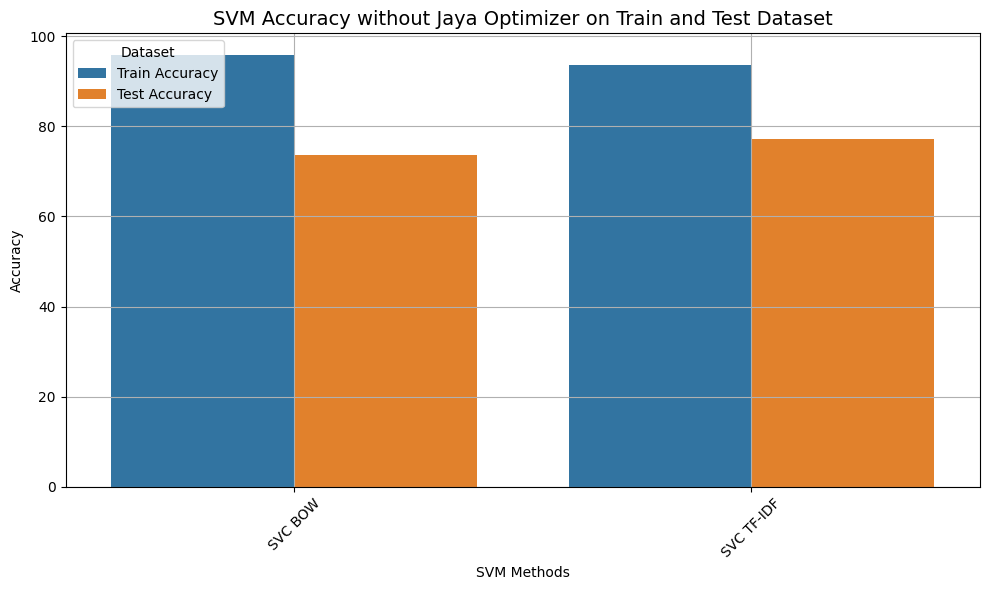

In [ ]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
svm_accuracy_df_pivot = svm_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=svm_accuracy_df_pivot)
plt.xlabel('SVM Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('SVM Accuracy without Jaya Optimizer on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

---

### `KNN without Jaya`

In [ ]:
## Using function to apply DRY concept in an intelligent way without repearting and rewriting code 
def knn_without_jaya(method: str): 
    ''' This Function is to train MODEL using the given method and returns the train and test accuracy.
    Args:
    ****
        (method: str) --> The method of features on of (BOW, TFIDF, Word2Vec, BERT)
    
    Returns:
    *******
        (acc_train_svc: float) --> The training accuracy 
        (acc_test_svc: float) --> The test accuracy
    ''' 
    
    ## Split the Dataset first --> Call the function
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    ## Knn without using jaya
    knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
    knn.fit(X_train, y_train)
    
    ## Accuracy
    y_pred_train_knn = knn.predict(X_train)
    y_pred_test_knn = knn.predict(X_test)
    
    acc_train_knn = round(100*accuracy_score(y_train, y_pred_train_knn), 4)
    acc_test_knn = round(100*accuracy_score(y_test, y_pred_test_knn), 4)
    
    ## I will return the model (In case we want it for inference in real time and deployment) with accuracies.
    return knn, acc_train_knn, acc_test_knn

`1. Using BOW`

In [ ]:
## BOW using KNN
knn_bow, acc_train_knn_bow, acc_test_knn_bow = knn_without_jaya(method='BOW')
print(f'Accuracy Score for Training Dataset using BOW using KNN without Jaya \t {acc_train_knn_bow} %')
print(f'Accuracy Score for Testing Dataset using BOW using KNN without Jaya \t {acc_test_knn_bow} %')

Accuracy Score for Training Dataset using BOW using KNN without Jaya 	 62.844 %
Accuracy Score for Testing Dataset using BOW using KNN without Jaya 	 48.1818 %


`2. Using TFIDF`

In [ ]:
## TFIDF using KNN
knn_tfidf, acc_train_knn_tfidf, acc_test_knn_tfidf = knn_without_jaya(method='TFIDF')
print(f'Accuracy Score for Training Dataset using TFIDF using KNN without Jaya \t {acc_train_knn_tfidf} %')
print(f'Accuracy Score for Testing Dataset using TFIDF using KNN without Jaya \t {acc_test_knn_tfidf} %')

Accuracy Score for Training Dataset using TFIDF using KNN without Jaya 	 69.0367 %
Accuracy Score for Testing Dataset using TFIDF using KNN without Jaya 	 52.7273 %


* `Combine all results for KNN without Jaya`

In [ ]:
## Combine all results of SVM wihtout Jaya in one DataFrame
acc_train_knn = [acc_train_knn_bow, acc_train_knn_tfidf]
acc_test_knn = [acc_test_knn_bow, acc_test_knn_tfidf]


## Create a DataFrame for KNN accuracies
data_knn = {
        'Method': ['KNN BOW', 'KNN TF-IDF'],
        'Train Accuracy': acc_train_knn,
        'Test Accuracy': acc_test_knn
            }

knn_accuracy_df = pd.DataFrame(data_knn)
knn_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,KNN BOW,62.8440,48.1818
1,KNN TF-IDF,69.0367,52.7273


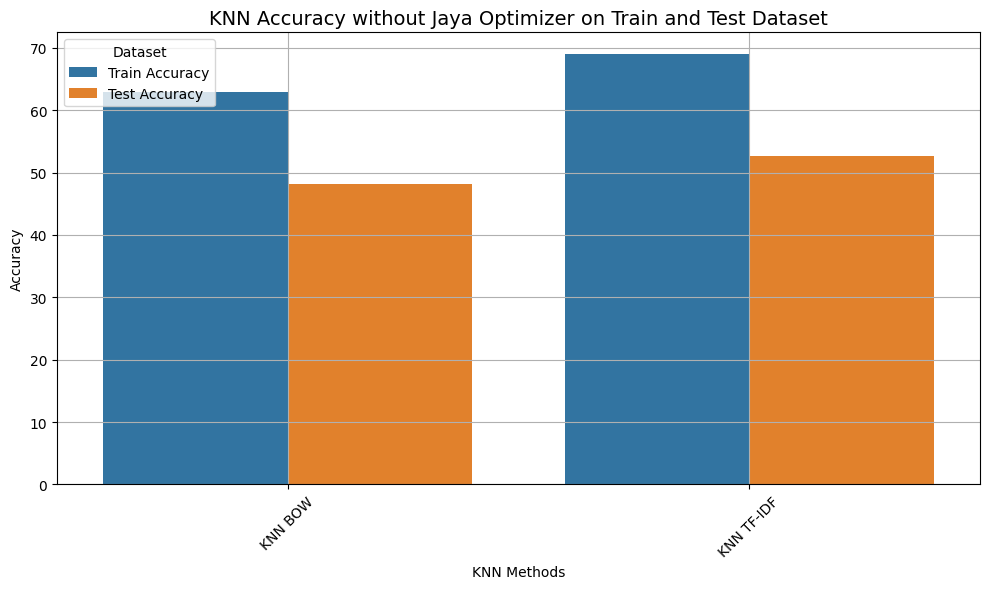

In [ ]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
knn_accuracy_df_pivot = knn_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=knn_accuracy_df_pivot)
plt.xlabel('KNN Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('KNN Accuracy without Jaya Optimizer on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

--------

### `Logistic Regression without Jaya`

In [ ]:
## Using function to apply DRY concept in an intelligent way without repearting and rewriting code 
def logistic_without_jaya(method: str): 
    ''' This Function is to train MODEL using the given method and returns the train and test accuracy.
    Args:
    ****
        (method: str) --> The method of features on of (BOW, TFIDF, Word2Vec, BERT)
    
    Returns:
    *******
        (acc_train_svc: float) --> The training accuracy 
        (acc_test_svc: float) --> The test accuracy
    ''' 
    
    ## Split the Dataset first --> Call the function
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    ## Knn without using jaya
    logistic = LogisticRegression(C=1.5, random_state=42, max_iter=10000, penalty='l2')
    logistic.fit(X_train, y_train)
    
    ## Accuracy
    y_pred_train_log = logistic.predict(X_train)
    y_pred_test_log = logistic.predict(X_test)
    
    acc_train_log = round(100*accuracy_score(y_train, y_pred_train_log), 4)
    acc_test_log = round(100*accuracy_score(y_test, y_pred_test_log), 4)
    
    ## I will return the model (In case we want it for inference in real time and deployment) with accuracies.
    return logistic, acc_train_log, acc_test_log

`1. Using BOW`

In [ ]:
## BOW using Logisitic
log_bow, acc_train_log_bow, acc_test_log_bow = logistic_without_jaya(method='BOW')
print(f'Accuracy Score for Training Dataset using BOW using Logistic without Jaya \t {acc_train_log_bow} %')
print(f'Accuracy Score for Testing Dataset using BOW using Logistic without Jaya \t {acc_test_log_bow} %')

Accuracy Score for Training Dataset using BOW using Logistic without Jaya 	 94.0367 %
Accuracy Score for Testing Dataset using BOW using Logistic without Jaya 	 70.9091 %


`2. Using TFIDF`

In [ ]:
## TFIDF using Logisitic
log_tfidf, acc_train_log_tfidf, acc_test_log_tfidf = logistic_without_jaya(method='TFIDF')
print(f'Accuracy Score for Training Dataset using TFIDF using Logistic without Jaya \t {acc_train_log_tfidf} %')
print(f'Accuracy Score for Testing Dataset using TFIDF using Logistic without Jaya \t {acc_test_log_tfidf} %')

Accuracy Score for Training Dataset using TFIDF using Logistic without Jaya 	 92.8899 %
Accuracy Score for Testing Dataset using TFIDF using Logistic without Jaya 	 71.8182 %


* `Combine all results for Logistic without Jaya`

In [ ]:
## Combine all results of Logisitc wihtout Jaya in one DataFrame
acc_train_log = [acc_train_log_bow, acc_train_log_tfidf]
acc_test_log = [acc_test_log_bow, acc_test_log_tfidf]


## Create a DataFrame for Logistic accuracies
data_log = {
        'Method': ['Log BOW', 'Log TF-IDF'],
        'Train Accuracy': acc_train_log,
        'Test Accuracy': acc_test_log
            }

log_accuracy_df = pd.DataFrame(data_log)
log_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,Log BOW,94.0367,70.9091
1,Log TF-IDF,92.8899,71.8182


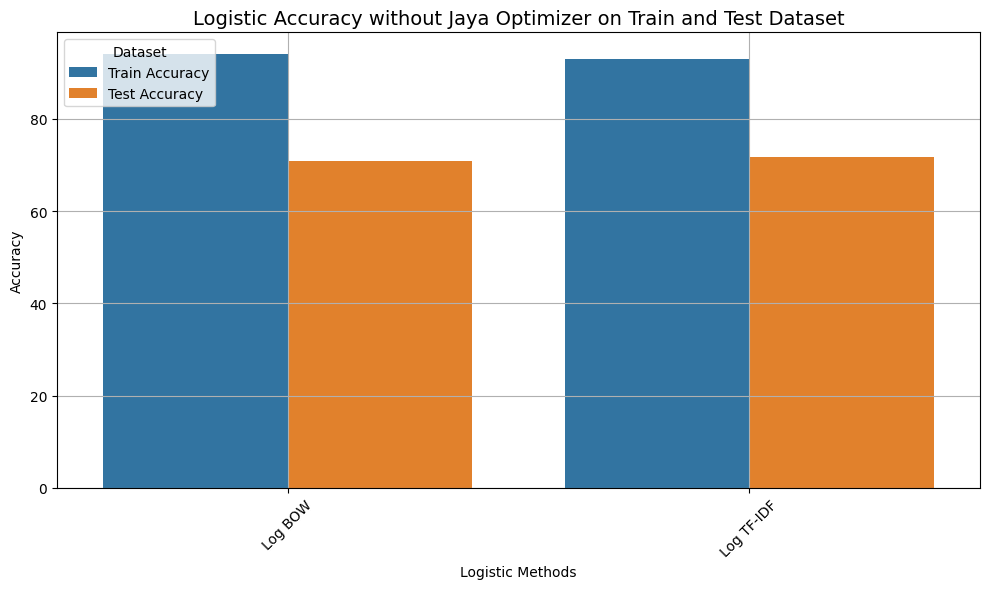

In [ ]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
log_accuracy_df_pivot = log_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=log_accuracy_df_pivot)
plt.xlabel('Logistic Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('Logistic Accuracy without Jaya Optimizer on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

----

### `Random Forest without Jaya`

In [ ]:
## Using function to apply DRY concept in an intelligent way without repearting and rewriting code 
def forest_without_jaya(method: str): 
    ''' This Function is to train MODEL using the given method and returns the train and test accuracy.
    Args:
    ****
        (method: str) --> The method of features on of (BOW, TFIDF, Word2Vec, BERT)
    
    Returns:
    *******
        (acc_train_svc: float) --> The training accuracy 
        (acc_test_svc: float) --> The test accuracy
    ''' 
    
    ## Split the Dataset first --> Call the function
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    ## RF without using jaya
    forest = RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42, max_features=0.8)
    forest.fit(X_train, y_train)
    
    ## Accuracy
    y_pred_train_forest = forest.predict(X_train)
    y_pred_test_forest = forest.predict(X_test)
    
    acc_train_forest = round(100*accuracy_score(y_train, y_pred_train_forest), 4)
    acc_test_forest= round(100*accuracy_score(y_test, y_pred_test_forest), 4)
    
    ## I will return the model (In case we want it for inference in real time and deployment) with accuracies.
    return forest, acc_train_forest, acc_test_forest

`1. Using BOW`

In [ ]:
## BOW using RF
forest_bow, acc_train_forest_bow, acc_test_forest_bow = forest_without_jaya(method='BOW')
print(f'Accuracy Score for Training Dataset using BOW using RandomForest without Jaya \t {acc_train_forest_bow} %')
print(f'Accuracy Score for Testing Dataset using BOW using RandomForest without Jaya \t {acc_test_forest_bow} %')

Accuracy Score for Training Dataset using BOW using RandomForest without Jaya 	 62.3853 %
Accuracy Score for Testing Dataset using BOW using RandomForest without Jaya 	 57.2727 %


`2. Using TFIDF`

In [ ]:
## TFIDF using RF
forest_tfidf, acc_train_forest_tfidf, acc_test_forest_tfidf = forest_without_jaya(method='TFIDF')
print(f'Accuracy Score for Training Dataset using TFIDF using RandomForest without Jaya \t {acc_train_forest_tfidf} %')
print(f'Accuracy Score for Testing Dataset using TFIDF using RandomForest without Jaya \t {acc_test_forest_tfidf} %')

Accuracy Score for Training Dataset using TFIDF using RandomForest without Jaya 	 63.3028 %
Accuracy Score for Testing Dataset using TFIDF using RandomForest without Jaya 	 57.2727 %


* `Combine all results for RF without Jaya`

In [ ]:
## Combine all results of RF wihtout Jaya in one DataFrame
acc_train_forest = [acc_train_forest_bow, acc_train_forest_tfidf]
acc_test_forest = [acc_test_forest_bow, acc_test_forest_tfidf]


## Create a DataFrame for RF accuracies
data_forest = {
        'Method': ['RF BOW', 'RF TF-IDF'],
        'Train Accuracy': acc_train_forest,
        'Test Accuracy': acc_test_forest
            }

forest_accuracy_df = pd.DataFrame(data_forest)
forest_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,RF BOW,62.3853,57.2727
1,RF TF-IDF,63.3028,57.2727


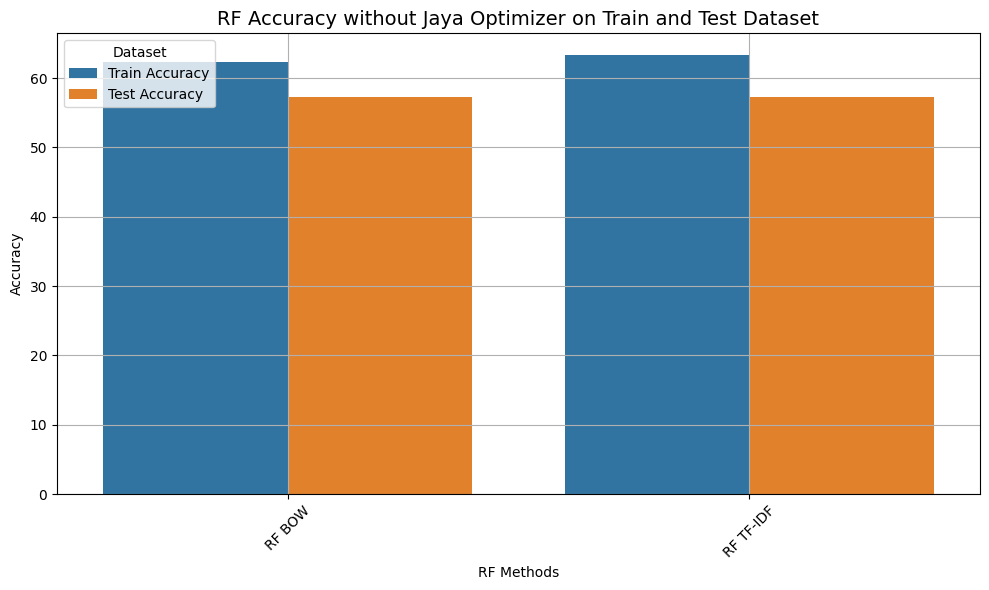

In [ ]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
forest_accuracy_df_pivot = forest_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=forest_accuracy_df_pivot)
plt.xlabel('RF Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('RF Accuracy without Jaya Optimizer on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

-----

### `Naive Bayes without Jaya`

In [ ]:
def naive_bayes_without_jaya(method: str): 
    ''' This Function is to train MODEL using the given method and returns the train and test accuracy.
    Args:
    ****
        (method: str) --> The method of features on of (BOW, TFIDF, Word2Vec, BERT)
    
    Returns:
    *******
        (acc_train_svc: float) --> The training accuracy 
        (acc_test_svc: float) --> The test accuracy
    ''' 
    
    ## Split the Dataset first --> Call the function
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    ## Naive Bayes without using jaya
    naive = GaussianNB()
    naive.fit(X_train, y_train)
    
    ## Accuracy
    y_pred_train_naive = naive.predict(X_train)
    y_pred_test_naive = naive.predict(X_test)
    
    acc_train_naive = round(100*accuracy_score(y_train, y_pred_train_naive), 4)
    acc_test_naive = round(100*accuracy_score(y_test, y_pred_test_naive), 4)
    
    ## I will return the model (In case we want it for inference in real time and deployment) with accuracies.
    return naive, acc_train_naive, acc_test_naive

`1. Using BOW`

In [ ]:
## BOW using naive bayes
naive_bow, acc_train_naive_bow, acc_test_naive_bow = naive_bayes_without_jaya(method='BOW')
print(f'Accuracy Score for Training Dataset using BOW using NaiveBayes without Jaya \t {acc_train_naive_bow} %')
print(f'Accuracy Score for Testing Dataset using BOW using NaiveBayes without Jaya \t {acc_test_naive_bow} %')

Accuracy Score for Training Dataset using BOW using NaiveBayes without Jaya 	 86.6972 %
Accuracy Score for Testing Dataset using BOW using NaiveBayes without Jaya 	 67.2727 %


`2. Using TFIDF`

In [ ]:
## TFIDF using naive bayes
naive_tfidf, acc_train_naive_tfidf, acc_test_naive_tfidf = naive_bayes_without_jaya(method='TFIDF')
print(f'Accuracy Score for Training Dataset using TFIDF using NaiveBayes without Jaya \t {acc_train_naive_tfidf} %')
print(f'Accuracy Score for Testing Dataset using TFIDF using NaiveBayes without Jaya \t {acc_test_naive_tfidf} %')

Accuracy Score for Training Dataset using TFIDF using NaiveBayes without Jaya 	 88.7615 %
Accuracy Score for Testing Dataset using TFIDF using NaiveBayes without Jaya 	 70.0 %


* `Combine all results for NB without Jaya`

In [ ]:
## Combine all results of Naive wihtout Jaya in one DataFrame
acc_train_naive = [acc_train_naive_bow, acc_train_naive_tfidf]
acc_test_naive = [acc_test_naive_bow, acc_test_naive_tfidf]


## Create a DataFrame for NB accuracies
data_naive = {
        'Method': ['NB BOW', 'NB TF-IDF'],
        'Train Accuracy': acc_train_naive,
        'Test Accuracy': acc_test_naive
            }

naive_accuracy_df = pd.DataFrame(data_naive)
naive_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,NB BOW,86.6972,67.2727
1,NB TF-IDF,88.7615,70.0000


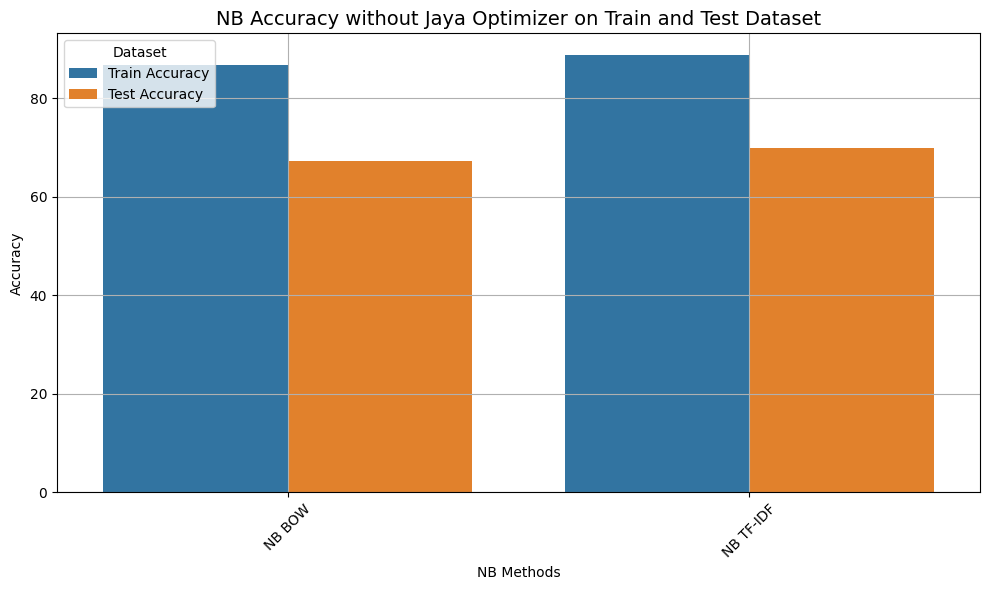

In [ ]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
naive_accuracy_df_pivot = naive_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=naive_accuracy_df_pivot)
plt.xlabel('NB Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('NB Accuracy without Jaya Optimizer on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

-------

### `XGBOOST without Jaya`

In [ ]:
def xgboost_without_jaya(method: str): 
    ''' This Function is to train MODEL using the given method and returns the train and test accuracy.
    Args:
    ****
        (method: str) --> The method of features on of (BOW, TFIDF, Word2Vec, BERT)
    
    Returns:
    *******
        (acc_train_svc: float) --> The training accuracy 
        (acc_test_svc: float) --> The test accuracy
    ''' 
    
    ## Split the Dataset first --> Call the function
    X_train, X_test, y_train, y_test = before_models(method=method)
    
    ## Gradient Boosting (GB)
    gboost = XGBClassifier(n_estimators=150, max_depth=5, learning_rate=0.01, colsample_bytree=0.8)
    gboost.fit(X_train, y_train)
    
    ## Accuracy
    y_pred_train_gboost = gboost.predict(X_train)
    y_pred_test_gboost = gboost.predict(X_test)
    
    acc_train_gboost = round(100*accuracy_score(y_train, y_pred_train_gboost), 4)
    acc_test_gboost = round(100*accuracy_score(y_test, y_pred_test_gboost), 4)
    
    return gboost, acc_train_gboost, acc_test_gboost

`1. Using BOW`

In [ ]:
## BOW using XGBoost
gboost_bow, acc_train_gboost_bow, acc_test_gboost_bow = xgboost_without_jaya(method='BOW')
print(f'Accuracy Score for Training Dataset using BOW using XGBOOST without Jaya \t {acc_train_gboost_bow} %')
print(f'Accuracy Score for Testing Dataset using BOW using XGBOOST without Jaya \t {acc_test_gboost_bow} %')

Accuracy Score for Training Dataset using BOW using XGBOOST without Jaya 	 67.6606 %
Accuracy Score for Testing Dataset using BOW using XGBOOST without Jaya 	 62.7273 %


`2. Using TFIDF`

In [ ]:
## TFIDF using XGBoost
gboost_tfidf, acc_train_gboost_tfidf, acc_test_gboost_tfidf = xgboost_without_jaya(method='TFIDF')
print(f'Accuracy Score for Training Dataset using TFIDF using XGBOOST without Jaya \t {acc_train_gboost_tfidf} %')
print(f'Accuracy Score for Testing Dataset using TFIDF using XGBOOST without Jaya \t {acc_test_gboost_tfidf} %')

Accuracy Score for Training Dataset using TFIDF using XGBOOST without Jaya 	 71.789 %
Accuracy Score for Testing Dataset using TFIDF using XGBOOST without Jaya 	 57.2727 %


* `Combine all results for XGBOOST without Jaya`

In [ ]:
## Combine all results of XGBOOST wihtout Jaya in one DataFrame
acc_train_gboost = [acc_train_gboost_bow, acc_train_gboost_tfidf]
acc_test_gboost = [acc_test_gboost_bow, acc_test_gboost_tfidf]


## Create a DataFrame for XGBOOST accuracies
data_gboost = {
        'Method': ['XGBOOST BOW', 'XGBOOST TF-IDF'],
        'Train Accuracy': acc_train_gboost,
        'Test Accuracy': acc_test_gboost
            }

gboost_accuracy_df = pd.DataFrame(data_gboost)
gboost_accuracy_df

,Method,Train Accuracy,Test Accuracy
0,XGBOOST BOW,67.6606,62.7273
1,XGBOOST TF-IDF,71.7890,57.2727


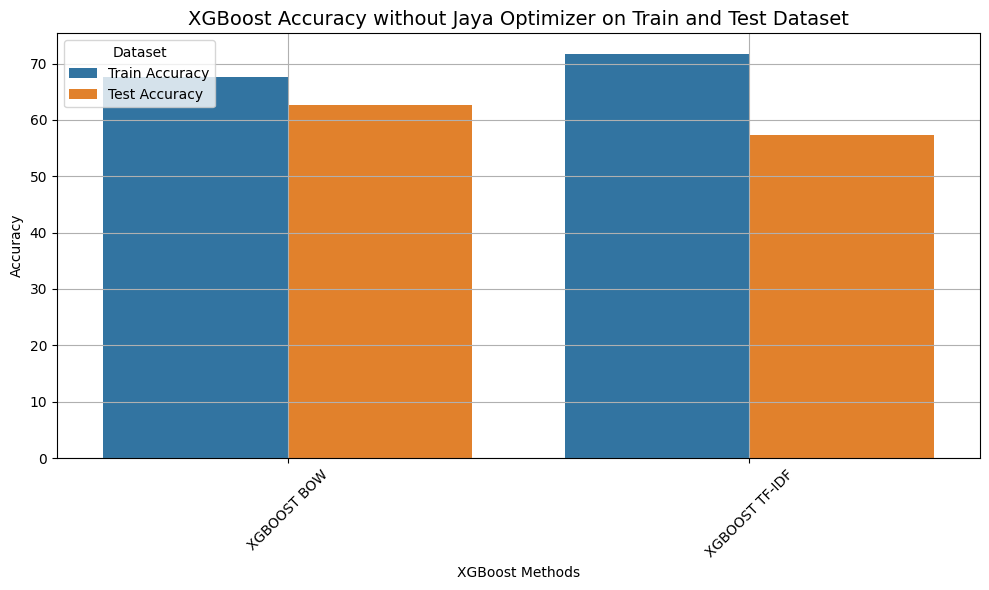

In [ ]:
## Pivot the DataFrame to have separate columns for Train and Test Accuracy
gboost_accuracy_df_pivot = gboost_accuracy_df.melt(id_vars='Method', var_name='Dataset', value_name='Accuracy')

## Create the grouped bar chart using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y='Accuracy', hue='Dataset', data=gboost_accuracy_df_pivot)
plt.xlabel('XGBoost Methods', color='k')
plt.ylabel('Accuracy', color='k')
plt.title('XGBoost Accuracy without Jaya Optimizer on Train and Test Dataset', fontsize=14, color='k')
plt.xticks(rotation=45)
plt.legend(title='Dataset', loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

--------------------

## <center> Done </center>

------------